In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as mpl
from IPython.core.pylabtools import figsize

In [2]:
figsize(15, 15)


#  Загрузка данных

In [3]:
df = pd.read_json('./prepared.json')

In [4]:
df.head()

,iso_code,date,new_cases,new_deaths,reproduction_rate,population_density,median_age,gdp_per_capita,cardiovasc_death_rate,diabetes_prevalence,hospital_beds_per_thousand,life_expectancy,human_development_index,population,rt
69,1,2020-03-11 21:00:00,3,0,0.0,54.422,18.6,1803.987,597.029,9.59,0.5,64.83,0.511,41128772,0.0
70,1,2020-03-12 21:00:00,0,0,0.0,54.422,18.6,1803.987,597.029,9.59,0.5,64.83,0.511,41128772,1.0
71,1,2020-03-13 21:00:00,0,0,0.0,54.422,18.6,1803.987,597.029,9.59,0.5,64.83,0.511,41128772,1.0
72,1,2020-03-14 21:00:00,0,0,0.0,54.422,18.6,1803.987,597.029,9.59,0.5,64.83,0.511,41128772,1.0
73,1,2020-03-15 21:00:00,3,0,0.0,54.422,18.6,1803.987,597.029,9.59,0.5,64.83,0.511,41128772,0.5


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 267713 entries, 69 to 318384
Data columns (total 15 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   iso_code                    267713 non-null  int64         
 1   date                        267713 non-null  datetime64[ns]
 2   new_cases                   267713 non-null  int64         
 3   new_deaths                  267713 non-null  int64         
 4   reproduction_rate           267713 non-null  float64       
 5   population_density          267713 non-null  float64       
 6   median_age                  267713 non-null  float64       
 7   gdp_per_capita              267713 non-null  float64       
 8   cardiovasc_death_rate       267713 non-null  float64       
 9   diabetes_prevalence         267713 non-null  float64       
 10  hospital_beds_per_thousand  267713 non-null  float64       
 11  life_expectancy             267713 non-null

Почему то не тот тип данных у даты

In [6]:
df.date = df.date.values.astype(float)

# Анализ данных

Так как данные уже подготовлены, то нужно лишь проанализировать зависимости и выбрать признаки для обучения

И так, сразу удалю rt, потому что он является производной новых случаев

In [7]:
df = df.drop(columns=['rt'])

<Axes: >

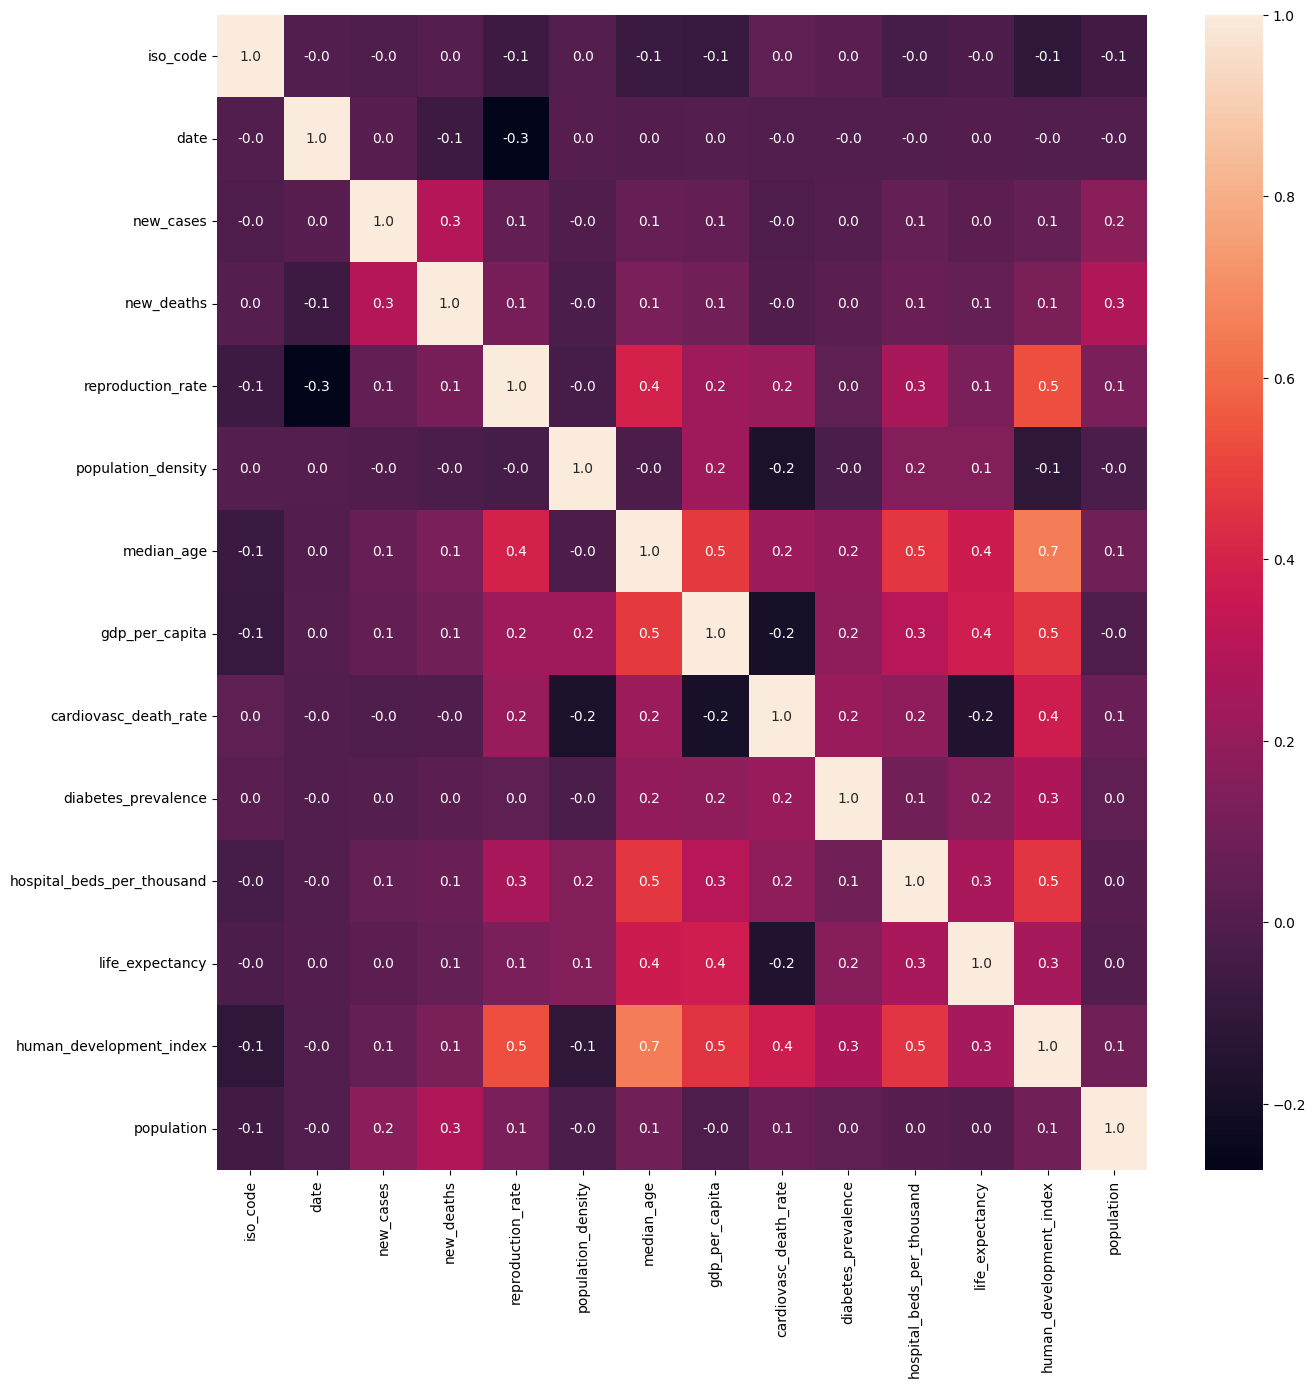

In [8]:
sb.heatmap(df.corr(), annot=True, fmt='.1f')

Зависимости довольно плохие, так что возьмем только новые смерти и популяцию из-за видимой зависимости, а так же дату и код страны, так как я считаю, что это может иметь влияние

In [9]:
filtered_df = df[['new_cases', 'new_deaths', 'population', 'date', 'iso_code']]

# Разбиение данных

In [10]:
x = filtered_df.drop(columns=['new_cases'])
y = filtered_df['new_cases']

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.4, random_state=42)

# Обучение моделей

In [13]:
def mae(y_true, y_pred):
    print(y_true, y_pred)
    return np.mean(abs(y_true - y_pred))

In [14]:
results = pd.DataFrame(columns=['name', 'score'])
predicts = {}


In [15]:


def get_result(name: str) -> dict:
    result = results[results.name == name].to_numpy()[0]
    return {
        'name': result[0],
        'score': result[1]
    }


In [16]:

def learn_and_score(model, name: str):
    model.fit(x_train, y_train)
    predicted = model.predict(x_test)

    score = round(model.score(x_test, y_test), 4)

    results.loc[len(results)] = {'name': name,
                                 'score': score}
    predicts[name] = predicted

    return score, predicted


In [17]:


def model_report(name: str):
    result = get_result(name)
    predicted = predicts[name]

    print(f'----- {name} -----')
    print('Accuracy score: {}%'.format(result['score'] * 100))
    print(mae(y_test, predicted))
    print('----------------------')


In [18]:


def total_report():
    sb.barplot(results, y='name', x='score')


### Линейная регрессия

Очень популярная модель

In [19]:
from sklearn.linear_model import LinearRegression


In [20]:
lr = LinearRegression()
LR = 'linear_regression'
learn_and_score(lr, LR)

(0.1055,
 array([ 4288.3609351 ,  -837.6384294 ,   856.67374601, ...,
          191.78042217,   633.29533445, -2532.55284592]))

In [21]:
model_report(LR)

----- linear_regression -----
Accuracy score: 10.549999999999999%
310829      11
224682       0
192946       0
43715        0
246122       1
          ... 
266261    1539
248251    1701
177677      54
200299      22
229343     283
Name: new_cases, Length: 107086, dtype: int64 [ 4288.3609351   -837.6384294    856.67374601 ...   191.78042217
   633.29533445 -2532.55284592]
3713.7870108844068
----------------------


Получается очень плохая точность, нужно что то думать, я не знаю, что может быть причиной этому

### Случайный лес

In [22]:
from sklearn.ensemble import RandomForestRegressor


In [23]:

random_forest = RandomForestRegressor(random_state=42)
RANDOM_FOREST = 'random forest'
learn_and_score(random_forest, RANDOM_FOREST)


(0.8233, array([ 13.26,   0.  ,   0.  , ...,  22.73,   2.64, 272.04]))

In [24]:
model_report(RANDOM_FOREST)

----- random forest -----
Accuracy score: 82.33%
310829      11
224682       0
192946       0
43715        0
246122       1
          ... 
266261    1539
248251    1701
177677      54
200299      22
229343     283
Name: new_cases, Length: 107086, dtype: int64 [ 13.26   0.     0.   ...  22.73   2.64 272.04]
841.2199702108586
----------------------


А вот это уже отлично, получается хорошее предсказание

### Градиентный бустинг

In [25]:
from sklearn.ensemble import GradientBoostingRegressor


In [26]:

boost = GradientBoostingRegressor(random_state=42)
BOOST = 'boost'
learn_and_score(boost, BOOST)

(0.6167,
 array([2646.0579752 ,  -26.17067929,  302.4564921 , ...,  143.6482173 ,
          14.00881857,  -41.50080822]))

In [27]:
model_report(BOOST)

----- boost -----
Accuracy score: 61.67%
310829      11
224682       0
192946       0
43715        0
246122       1
          ... 
266261    1539
248251    1701
177677      54
200299      22
229343     283
Name: new_cases, Length: 107086, dtype: int64 [2646.0579752   -26.17067929  302.4564921  ...  143.6482173    14.00881857
  -41.50080822]
2131.0947104462234
----------------------


Несколько хуже, чем лес, но тоже неплохо

### Соседи

In [28]:
from sklearn.neighbors import KNeighborsRegressor

In [29]:
kneighbors = KNeighborsRegressor(n_neighbors=8)
KNEIGHBORS = 'neighbors'
learn_and_score(kneighbors, KNEIGHBORS)

(0.004,
 array([ 309.5  ,    0.   ,    5.75 , ...,   58.5  , 1484.625,   17.25 ]))

In [30]:
model_report(KNEIGHBORS)

----- neighbors -----
Accuracy score: 0.4%
310829      11
224682       0
192946       0
43715        0
246122       1
          ... 
266261    1539
248251    1701
177677      54
200299      22
229343     283
Name: new_cases, Length: 107086, dtype: int64 [ 309.5      0.       5.75  ...   58.5   1484.625   17.25 ]
3517.959401789216
----------------------


Самая ужасная точность, это даже смешно

# Промежуточные итоги

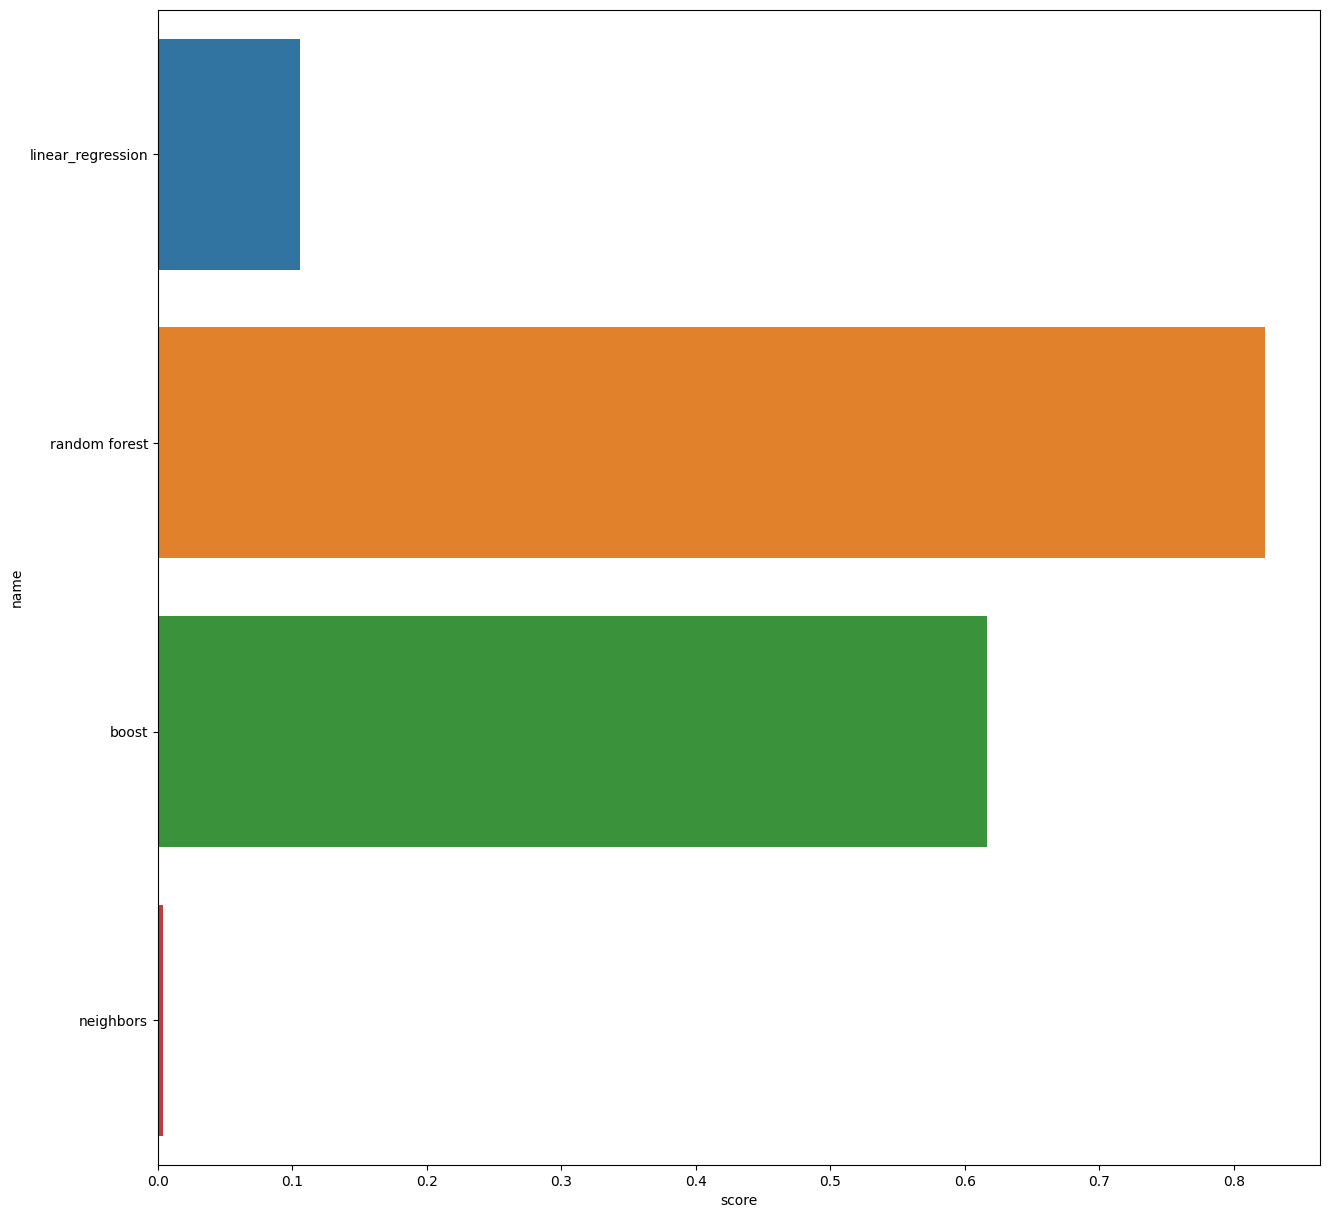

In [31]:
total_report()

Какие либо значимые результаты показал только лес и бустинг, так что попробую улучшить их

# Гиперпараметры

In [32]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import math

Некоторые функции для автоматизации подбора параметров и показывания метрик


In [33]:
def random_search(model, params, X_train):
    search = RandomizedSearchCV(
        model, params, random_state=42, n_jobs=-2, return_train_score=True)
    search.fit(X_train, y_train)
    return pd.DataFrame(search.cv_results_).sort_values(by='mean_test_score', ascending=True)

In [34]:
def results_report(results: pd.DataFrame, in_row=3):
    columns = list(
        filter(lambda name: name.startswith('param_'), results.columns))

    row_count = math.ceil(len(columns) / in_row)

    _, axs = mpl.subplots(nrows=row_count, ncols=in_row)

    for index, column in enumerate(columns):
        col = index % in_row
        row = index // in_row
        sb.barplot(results, x=column, y='mean_test_score', ax=axs[row, col])

In [35]:
def grid_search(model, params, X_train):
    search = GridSearchCV(model, params, n_jobs=-2, return_train_score=True)
    search.fit(X_train, y_train)
    return search.best_params_


## Лес


In [36]:
base_forest_params = {
    'random_state': 42,
    'n_jobs': -2
}

In [39]:
search_forest_params = {
    'n_estimators': np.arange(50, 400, 50),
    'max_depth': np.concatenate([np.arange(5, 16, 2), [None]]),
    'min_samples_leaf': np.arange(1, 10, 2),
    'min_samples_split': np.arange(2, 15, 2),
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

In [40]:
base_forest = RandomForestRegressor(**base_forest_params)
forest_results = random_search(base_forest, search_forest_params, x_train)

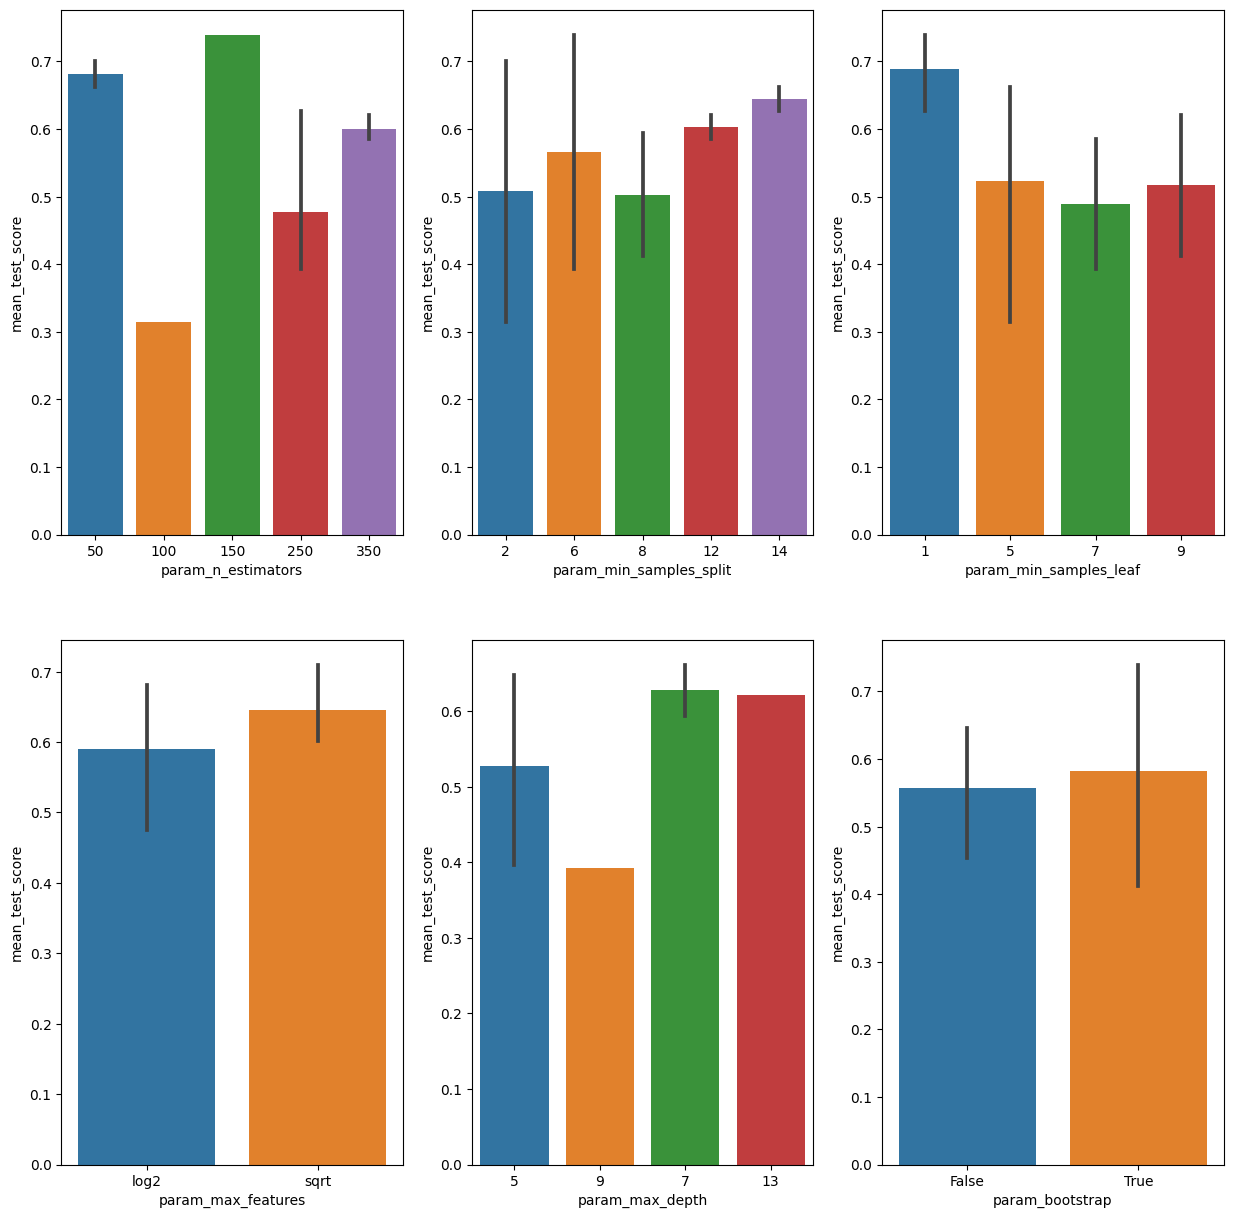

In [41]:
results_report(forest_results)

Ух, много различий

Точно можно сказать, что:

- max_features - sqrt
- bootstrap - True

Нужно еще проверить:

- n_estimators - between 130 and 180
- max_depth - between 6 and 9
- min_samples_leaf - between 1 and 4
- min_samples_split - between 1 and 7 and between 13 and 15


In [42]:
prebest_forest_params = {
    'max_features': 'sqrt',
    'bootstrap': True,
}

grid_forest_params = {
    'n_estimators': np.arange(130, 180, 10),
    'min_samples_split': np.concatenate([np.arange(1, 7, 1), np.arange(13, 15, 1)]),
    'min_samples_leaf': np.arange(1, 4, 1),
    'max_depth': np.arange(6, 9, 1),
}

In [43]:
prebest_forest = RandomForestRegressor(
    **base_forest_params, **prebest_forest_params)
best_forest_params = grid_search(prebest_forest, grid_forest_params, x_train)

In [ ]:
best_forest = RandomForestRegressor(**base_forest_params, **prebest_forest_params, **best_forest_params)
BEST_FOREST='best forest'
learn_and_score(base_forest, BEST_FOREST)

C:\Users\VPR\AppData\Local\Temp\ipykernel_3016\3754592802.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x_train, y_train)


(0.8456, array([0, 0, 0, ..., 1, 1, 0]))

----- best forest -----
Accuracy score: 84.56%
              precision    recall  f1-score   support

           0       0.85      0.90      0.88     44178
           1       0.88      0.86      0.87     30742
           2       0.43      0.30      0.35      5394

    accuracy                           0.85     80314
   macro avg       0.72      0.69      0.70     80314
weighted avg       0.84      0.85      0.84     80314

Confusion matrix
----------------------


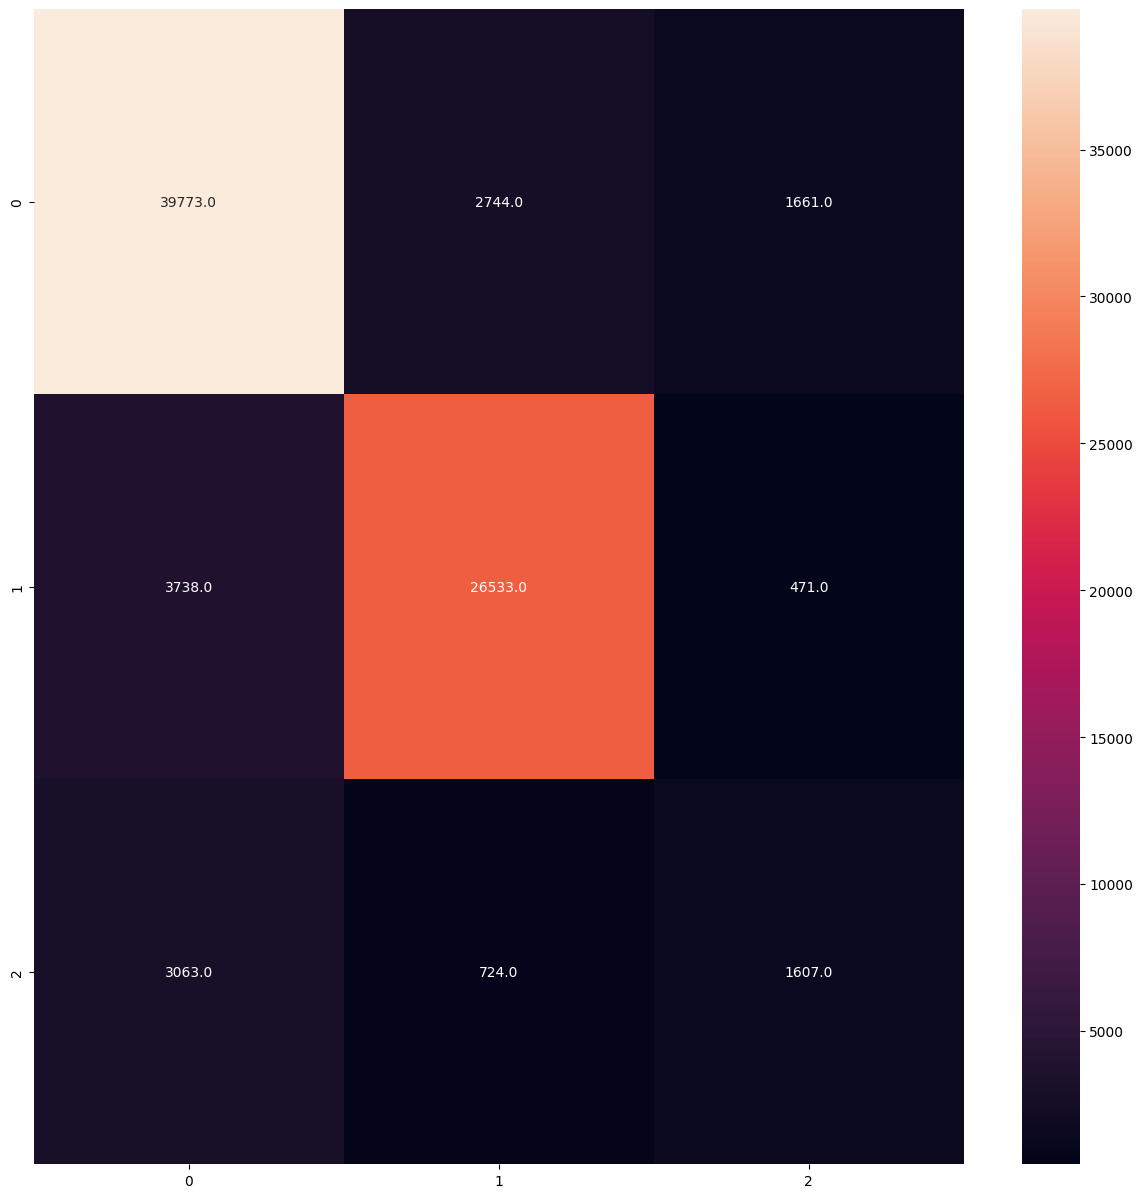

In [ ]:
model_report(BEST_FOREST)